# 北理2023室内小物体目标检测比赛

| 姓名   | 学号       | CodaLab ID |
| ------ | ---------- | ---------- |
| 董林康 | 1120212477 | linkdom    |



## 比赛介绍

比赛网址👉[CodaLab - Competition (upsaclay.fr)](https://codalab.lisn.upsaclay.fr/competitions/13091?secret_key=0a4c6588-2590-437f-a87e-bba156d0c317#learn_the_details-overview)

小物体目标检测任务，一共有21个类，33354个训练集图片，16362个测试集图片，在训练集中每种类别的数量分布不均匀，如下图所示：

![distribution](image/%E7%B1%BB%E5%88%AB%E6%A0%87%E6%B3%A8%E6%95%B0%E9%87%8F%E7%BB%9F%E8%AE%A1.png)



### 比赛打榜结果

下面的结果是自己在7月7号的最后一次提交，由于数据没有在完整测试集上生成所有图片的bbox（只生成了一半数据），所以提交的时候报错了，目前的版本是在华为云中导出最后的`test.csv`文件，有接近8000张测试集图片的预测结果（自己的华为云的代金券也用完了，后续计划使用colab加载参数再推理一次数据，看见平台截止时间为7月20号）。

![ranl](image/rank.png)



### 工作简单介绍

#### 训练平台

自己从头到尾手写的第一个目标检测模型`Resnet50+FPN+SSD`，没有使用过任何在Coco数据上预训练过的模型，采用的算力平台包括在华为云的ModelArts和Google的colab，使用的显卡分别是Tesla V100和Tesla T4：

| ModelArts(Tesla V100) | colab(Tesla T4) |
| :-------: | :---: |
| ![ModelArts](image/lab_modelarts.png) | ![colab](image/lab_colab.png) |



#### 采用模型及最后效果

从加载数据集，数据预处理，定义模型，模型训练，模型评估都是一点一点手写完成的，定义模型部分的backbone和neck自己是分别参考了YOLO和Cascade R-CNN的架构（最终代码自己手写实现），最终backbone实现了Resnet50和Resnet101两个版本，neck采用FPN，head采用了SSD的架构，在下面的定义模型部分会详细介绍，最后实现的目标检测效果如下图所示：

| 算力平台 | 原标注与预测结果对比 | 训练epoch | 
| :-------: | :---: | :---: |
| ModelArts(Tesla V100) | ![ma](image/predict_modelarts.png) | 10 |
| colab(Tesla T4) | ![colab](image/predict_colab.png) | 10 |

由于华为云上的测试结果要比colab上的结果好很多，所以最后的提交结果及下面训练评估流程均是在华为云上部署的。colab运行的版本作为本大作业附件提交。两个平台的开发不是同时进行的，但由于考虑到算力资源限制问题每个平台的模型训练均跑了10个epoch（colab上的GPU有时间限制，ModelArts上的GPU有费用限制，最后每个模型均是只跑了10epoch，两个平台的训练总时间在10个多小时）

> 在colab和modelarts上的训练集的`batch_size`均设置为128，`learning_rate`均设置为0.001，每五个epoch学习率衰减为原来的0.1，最后训练10个epoch，最后评估方法借鉴了d2l中评估TinySSD的方法，计算了分类的准确率和bbox的mae，最终每个bbox的准确率在0.98，而bbox的mae在0.02左右，由于训练轮次较少，下一步工作可以考虑进一步训练。



#### 代码结构说明

- `dl_detection`：数据集文件夹，包括`train`和`test`和`annotations`三个子文件夹，分别存放训练集和测试集图片和训练集的标注文件（在这里不作为最终文件上传lexue）
- `image` 存放本notebook中的图片
- `mydet` 自己手写的目标检测模型代码包，文件命名参考了mmdetection的命名规范（代码为自己写的） 
  - `anchor.py` 存放生成锚框的代码   
  - `backbone.py` 存放backbone代码
  - `head.py` 存放head代码
  - `neck.py` 存放neck代码
  - `loss.py` 存放模型损失函数代码
  - `model.py` 存放总模型代码
  - `eval.py` 存放模型评估代码
  - `bbox` 是`mydet`的子包，实现包括bbox分配，bbox编码，bbox后处理，iou和nms等函数
- `utils` 一些工具函数，部分参考了李沐的d2l的代码

本notebook中会给出用到的包的代码，具体实现均作为附件提交。



## 配置华为云的环境

在华为云上选择的是`Tesla V100-PCIE-32GB`的显卡，我们先查看一下GPU环境，再安装需要用到的包：

```python
torch
torchvision
gradio
torchinfo
pycocotools
```

> 华为云可以很轻松的创建notebook后从OBS服务获取上传的数据

In [1]:
!nvidia-smi

Wed Jul  5 17:13:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  On   | 00000000:00:0D.0 Off |                    0 |
| N/A   40C    P0    41W / 250W |      0MiB / 32510MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -r requirements.txt

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
You should consider upgrading via the '/home/ma-user/anaconda3/envs/PyTorch-1.8/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
# !pip uninstall numpy -y

In [4]:
# !pip install numpy

## 加载数据

这一部分中我们加载训练集上33354张图片的数据到`Cocodata_train `变量中，具体代码实现如下（已封装到`utils.data`包中）：

```python
def read_Cocodata_train(is_transform = True):
    """
    读取COCO数据集
    @param is_transform: 是否对数据集进行转换
    @return: Cocodata_train 数据集
    @note: 该数据集包含了训练数据集中的所有图片及其标注，在测试的时候可以不transform直接查看数据集中的图片
    其中target的第一个维度为图片中bbox的个数，最多为50个，如果图片中bbox的个数小于50个，则用0进行填充bbox，用0进行填充cls
    cls的label为0-21，bbox的坐标为相对坐标，即x_min, y_min, x_max, y_max的值为0-1
    """

    if is_transform == False:
        return torchvision.datasets.CocoDetection(
            root = train_data_dir, 
            annFile = train_anno_fname
        )

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Resize((256, 256))
    ])

    # 读取训练数据集
    Cocodata_train = torchvision.datasets.CocoDetection(
        root = train_data_dir, 
        annFile = train_anno_fname, 
        transform = transform,
        target_transform = target_transform  # 在utils.data定义
    )

    return Cocodata_train

def show_sample(Cocodata_train, idx):
    """
    显示数据集中的样本（使用plt画出bbox和cls）
    @param Cocodata_train: 没有transform的数据集
    @param idx: 样本索引
    @return: None
    """
    img, anno = Cocodata_train[idx]
    labels = []
    bboxs = []
    for elem in anno:
        labels.append(elem['category_id'])
        bboxs.append(elem['bbox'])
    from utils.draw import draw_bboxs
    draw_bboxs(
        img,
        bboxs,
        labels,
    )
    
```

下面先不对数据集进行transform，直接查看数据集中的图片：


loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


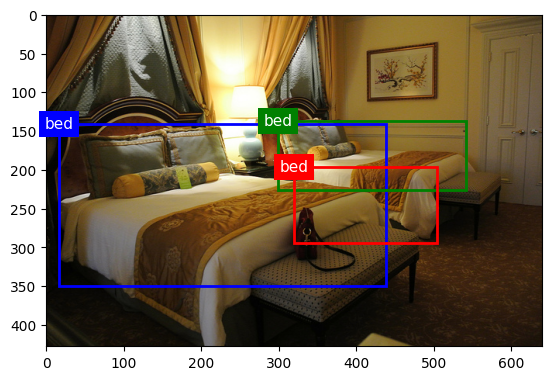

In [5]:
from utils.data import read_Cocodata_train, show_sample
Cocodata_train = read_Cocodata_train(is_transform = False)
show_sample(Cocodata_train, 0)

### 加载训练集数据

加载训练集数据并查看第一个样本的shape

In [6]:
Cocodata_train = read_Cocodata_train(is_transform = True)

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!


In [7]:
Cocodata_train[0][0].shape, Cocodata_train[0][1].shape

(torch.Size([3, 256, 256]), torch.Size([50, 5]))

## 定义模型

在定义模型的部分，最后实现的模型`Resnet50+FPN+SSD`架构如下图所示，（由于时间原因没有使用`Resnet101`作为backbone进行进一步的尝试）：

![model](image/Resnet50_FPN_SSD.png)

上图使用drawio绘制，橙色小方块表示带参数的网络层、灰色立方体代表图片或特征图（下面标有维度，以一个batch_size为例）、紫色小方块代表不带参数的网络层或功能函数。从左到右的三个紫色、蓝色、黄色方块分别代表了backbone，neck和head的模块。

在上图中，backbone采用了Resnet50，neck采用了FPN，head采用了SSD的架构，下面分别介绍backbone，neck和head的具体实现及介绍。


### BACKBONE

backbone采用了Resnet50的预训练模型，具体的架构图如下：

| backbone框架 | resnet原论文中的结构 |
| ------------ | -------------------- |
| ![backbone](image/Resnet50_small.png)      | ![paper](image/resnet_paper.png)      |

其中以一个batch_size为例，输入图片的维度为`[batch_size, 3, h, w]`（在这里默认图片是经过transform的，在本网络中 h = w = 256），则经过四个conv块的下采样之后，输出有四个尺度的特征图，维度分别为

- [batch_size, 256, h/4, w/4]
- [batch_size, 512, h/8, w/8]
- [batch_size, 1024, h/16, w/16]
- [batch_size, 2048, h/32, w/32]

其中特征图的宽高越小，感受野越大，语义信息越丰富，其预测的尺度就是更加高层的信息，因此我们将这四个特征图的张量作为neck的输入，即作为FPN的输入。（在这一部分中我们一开始加载完resnet50的预训练权重时就冻结网络的参数了，因为训练轮次不够多，最后我们没有进行微调。）

下面是该部分的代码实现，使用`torchvision.models`直接加载预训练模型，外面只需要自己定义输出即可：


```python

class Backbone(torch.nn.Module):
    """
    ResNet-50的backbone
    @return: list，包含4个元素，每个元素是一个尺度下的feature map 
    """
    def __init__(
            self, 
            model = "resnet50",
            freeze_backbone = True
        ):
        """
        @param model: str，表示使用的backbone模型，目前只支持resnet50和resnet101
        @param freeze_backbone: bool，表示是否冻结backbone的参数
        """
        super().__init__()
        # 这里可以选择使用预训练权重，也可以不使用（也可以改成其它预训练模型）
        if model == "resnet50":
            self.resnet = models.resnet50(pretrained=True)
        elif model == "resnet101":
            self.resnet = models.resnet101(pretrained=True) 
        else:
            raise NotImplementedError("目前只支持resnet50和resnet101")

        # 冻结backbone的参数
        if freeze_backbone:
            self._freeze_backbone()
    
    def _freeze_backbone(self):
        """
        冻结backbone的参数，即不对backbone的参数进行更新
        """
        for param in self.resnet.parameters():
            param.requires_grad = False
            
    
    def forward(self, x):
        """
        Backbone的forward函数，返回一个list，包含4个元素，每个元素是一个tensor
        @param x: 输入的tensor [batch_size, 3, h, w]
        @return: list，包含4个元素，每个元素是一个tensor 
        @note: 输出的4个tensor的shape分别是：
            [batch_size, 256, h/4, w/4]
            [batch_size, 512, h/8, w/8]
            [batch_size, 1024, h/16, w/16]
            [batch_size, 2048, h/32, w/32]
        @example:
            >>> backbone = Backbone()
            >>> x = torch.randn(1, 3, 512, 512)
            >>> output = backbone(x)
            >>> print(output[0].shape)
            >>> print(output[1].shape)
            >>> print(output[2].shape)
            >>> print(output[3].shape)
            torch.Size([1, 256, 128, 128])
            torch.Size([1, 512, 64, 64])
            torch.Size([1, 1024, 32, 32])
            torch.Size([1, 2048, 16, 16])
        """
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        output = []

        for i in range(4):
            x = getattr(self.resnet, f'layer{i+1}')(x)
            output.append(x)

        return output
```

### NECK

neck采用了FPN(Feature Pyramid Networks，特征金字塔)的结构，具体的架构图如下：

<!-- ![neck](image/FPN.png) -->

<img src="image/FPN.png" alt="neck" width=600px/>

从上面的架构图外面不难看出FPN有参数的只有在backbone侧面卷积过来的1x1卷积核以及将上下特征图相加后处理输出的3x3卷积核，其它的都是不带参数的网络层或功能函数。而上采样的原理就是将上面宽高较小的特征图进行插值，使得其尺度和的浅层输出的特征图宽高一致，然后再将两个特征图进行相加即可，上采样的原理图如下：

<!-- ![upsample](image/upsample_FPN.png) -->

<img src="image/upsample_FPN.png" alt="upsample" width=400px/>

举个例子，左图为2x2的特征图，我们需要将左图进行上采样，使得其尺度和右图4x4的特征图一致，这里具体实现采用的是最近邻插值，即右图的每个无标记像素点的值都是直接复制到右图对应的四个像素点上即可（相同颜色区域的像素值一致）。

总而言之FPN的具体思想是实现上采样的特征图和下采样的特征图进行融合，从而得到更加丰富的特征图（并且统一了通道数为256输出给head模块进行分类和回归工作），下面是FPN的具体实现代码：：

```python
class Neck(torch.nn.Module):
    """
    使用FPN作为neck
    @return: list，包含5个元素，每个元素是一个tensor，表示neck输出的5个尺度下的特征图
    """
    def __init__(
            self, 
            in_channels_list = [256, 512, 1024, 2048],
            out_channels = 256,
            num_outs = 5
        ):
        """
        @param in_channels_list: list，包含4个元素，每个元素是一个int，表示backbone输出的4个tensor的通道数
        @param out_channels: int，表示neck输出的tensor的通道数
        """
        super().__init__()
        self.in_channels_list = in_channels_list
        self.out_channels = out_channels
        self.num_outs = num_outs

        self.lateral_convs = torch.nn.ModuleList() # lateral convs （侧面卷积）
        self.fpn_convs = torch.nn.ModuleList() # fpn convs （FPN卷积）
        for in_channels in in_channels_list:
            self.lateral_convs.append(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size=1)
            )
            self.fpn_convs.append(
                torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            )
        

    def forward(self, x):
        """
        @param x: list，包含4个元素，每个元素是一个tensor，表示backbone输出的4个tensor
        @return: list，包含5个元素，每个元素是一个tensor，表示neck输出的5个tensor
        @note: 输出的5个tensor的shape分别是：
            [batch_size, out_channels, h/4, w/4]
            [batch_size, out_channels, h/8, w/8]
            [batch_size, out_channels, h/16, w/16]
            [batch_size, out_channels, h/32, w/32]
            [batch_size, out_channels, h/64, w/64]
        @example:
            >>> import torch
            >>> from mydet.neck import Neck
            >>> from mydet.backbone import Backbone
            >>> neck = Neck()
            >>> backbone = Backbone()
            >>> x = backbone(torch.randn(1, 3, 512, 512))
            >>> print("len(x):", len(x))
            >>> for i in range(len(x)):
            >>>     print("x[{}].shape:".format(i), x[i].shape)
            >>> y = neck(x)
            >>> print("len(y):", len(y))
            >>> for i in range(len(y)):
            >>>     print("y[{}].shape:".format(i), y[i].shape)
            len(x): 4
            x[0].shape: torch.Size([1, 256, 128, 128])
            x[1].shape: torch.Size([1, 512, 64, 64])
            x[2].shape: torch.Size([1, 1024, 32, 32])
            x[3].shape: torch.Size([1, 2048, 16, 16])
            len(y): 5
            y[0].shape: torch.Size([1, 256, 128, 128])
            y[1].shape: torch.Size([1, 256, 64, 64])
            y[2].shape: torch.Size([1, 256, 32, 32])
            y[3].shape: torch.Size([1, 256, 16, 16])
            y[4].shape: torch.Size([1, 256, 8, 8])
        """

        # 侧面卷积传播，将backbone的输出通道数经过1x1kernal统一转换为out_channels
        backbone_laterals = [layer_conv(backbone_output) for layer_conv, backbone_output in zip(self.lateral_convs, x)]
        
        # 从后往前遍历 Top-Down Pathway
        for i in range(len(backbone_laterals)-1, 0, -1):
            backbone_laterals[i-1] += torch.nn.functional.interpolate(backbone_laterals[i], scale_factor=2, mode='nearest')

        # FPN卷积传播，将backbone的输出通道数经过3x3kernal统一转换为out_channels
        fpn_outputs = [fpn_conv(backbone_lateral) for fpn_conv, backbone_lateral in zip(self.fpn_convs, backbone_laterals)]

        # 将超出num_outs个tensor输出全部为顶层tensor通道宽高的1/2
        for i in range(len(fpn_outputs), self.num_outs):
            fpn_outputs.append(torch.nn.functional.max_pool2d(fpn_outputs[-1], kernel_size=1, stride=2))

        return fpn_outputs
```

### HEAD

前面我们已经将backbone的输出通过neck模块进行了特征融合，得到了5个尺度的特征图，接下来我们需要对这些特征图进行分类和回归，这里我们采用的是SSD中的head模块，其具体结构如下图所示：

| 本代码中的SSDHead模块 | d2l中的TinySSD |
| :------------------: | :------------: |
| ![SSD1](image/SSD2.png) | ![SSD](image/SSD.png) |

HEAD部分的代码是部分参考了d2l中的TinySSD和mmdection中SSDhead的代码实现的，最终的模型和TinySSD不同，在输出最后的分类和回归之前我们经过了几个堆叠的3x3卷积层，这样可以增加一点模型的非线性。在上面的模型架构图中，我们每一个尺度下生成的特征图都有对应的锚框生成器去匹配该尺度，越是上面的特征图（上层比较抽象特征）我们认为其关于原图像的感受野越大（或者说语义越丰富），于是就分配相对于原图像而言较大的锚框；对于下面的浅层预测出来的特征图，我们就认为这是对小的物体检测更加的吻合，就分配小锚框，根据这一点我们选取好了对应的ratio(长宽比)和size(缩放比)，从而生成了对应的锚框，而且为了方便理解，这里利用gradio库来写了一个小的交互界面，代码打包放在`utils.gradio`，具体实现效果如下，执行代码：

```python
from utils.gradio import show_multi_anchors_app # 查看sizes和ratios选取的效果，在训练时可以不执行这里

sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5

# 将sizes和ratios转换为一维列表
sizes1d = [size for sizes_per_layer in sizes for size in sizes_per_layer]
ratios1d = ratios[0]

show_multi_anchors_app(sizes1d, ratios1d)
```

执行代码最终的效果如下图所示：

![anchor_generator](image/anchor.gif)

选取好对应的sizes和ratios之后我们就可以开始定义最后的head模型了，最终实现的代码放在了`mydet/head.py`中，其代码如下所示：

```python
class Head(torch.nn.Module):
    """
    使用SSDHead作为head
    @return: anchors, cls_preds, bbox_preds
    """
    def __init__(
            self,
            num_classes = 21,
            in_channels = [256, 256, 256, 256, 256],
            stacked_convs: int = 0,
            sizes = [[0.2 , 0.272], 
                     [0.37, 0.447], 
                     [0.54, 0.619], 
                     [0.71, 0.79 ], 
                     [0.88, 0.961]],
            ratios = [[1, 2, 0.5]] * 5,
            bbox_dim = 4,
        ):
        """
        @param num_classes: int，表示类别数，不包括背景
        @param in_channels: list，包含5个元素，每个元素是一个int，
        表示neck输出的5个tensor的通道数
        @param stacked_convs: int，表示head中的卷积层数
        @param sizes: list，包含5个元素，每个元素是一个list，
        表示该尺度特征图上的anchor的缩放比例
        @param ratios: list，包含5个元素，每个元素是一个list，表示该尺度特征图上的anchor的宽高比例
        @param bbox_dim: int，表示bbox的维度（有人也命名为loc_dim），一般是4
        """
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.sizes = sizes
        self.ratios = ratios
        self.bbox_dim = bbox_dim

        self.cls_convs = torch.nn.ModuleList()
        self.reg_convs = torch.nn.ModuleList()

        # 构建每个尺度上的锚框生成器
        self.anchor_generators = []

        for in_channel, size, ratio in zip(in_channels, sizes, ratios):
            # 每个尺度上的一个像素点对应anchor的数量
            num_anchors = len(size) + len(ratio) - 1

            # 构建head中的卷积层
            bbox_layers = []
            cls_layers = []
            # 先构建前面卷积层
            for i in range(stacked_convs):
                bbox_layers.append(
                    torch.nn.Conv2d(in_channel, in_channel, 
                                    kernel_size=3, padding=1)
                )
                cls_layers.append(
                    torch.nn.Conv2d(in_channel, in_channel, 
                                    kernel_size=3, padding=1)
                )
                bbox_layers.append(torch.nn.ReLU())
                cls_layers.append(torch.nn.ReLU())

            # 构建最后的分类和回归层
            bbox_layers.append(
                torch.nn.Conv2d(in_channel, num_anchors * bbox_dim, kernel_size=3, padding=1)
            )
            cls_layers.append(
                torch.nn.Conv2d(in_channel, num_anchors * (num_classes+1), kernel_size=3, padding=1)
            )

            # 构建该尺度上的锚框生成器
            self.anchor_generators.append(
                AnchorGenerator(size, ratio)
            )
        
            # 添加该尺度上的卷积层添加到cls_convs和reg_convs中
            self.cls_convs.append(torch.nn.Sequential(*cls_layers))
            self.reg_convs.append(torch.nn.Sequential(*bbox_layers))

    def flatten_pred(self, pred):
        """
        将预测结果变换成二维数组
        @param pred: 输出
        @return: 二维数组
        @note: (批量大小, 通道数, 高, 宽) -> (批量大小, 高, 宽, 通道数) -> (批量大小, 高 * 宽 * 通道数)
        """
        return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

    def concat_preds(self, preds):
        """
        将多尺度的预测结果拼接
        @param preds: 预测结果列表
        @return: 拼接后的预测结果
        @note: preds中的每个元素形状为(批量大小, \sum_i{高_i * 宽_i * 通道数_i}) 其中i表示第i个尺度
        """
        return torch.cat([self.flatten_pred(p) for p in preds], dim=1)

    def forward(self, x): 
        """
        在head中前向传播上游的neck输出的特征，生成anchors，得到head的输出cls_preds和bbox_preds
        @param x: list，包含5个元素，每个元素是一个tensor，表示neck输出的5个tensor
        @return: anchors, cls_preds, bbox_preds
        @note: `cls_preds`和`bbox_preds`的每个元素都是一个tensor，
        
        拼接之前：
        - `cls_preds`的shape是`(batch_size, num_anchors * (num_classes+1), h, w)`
        - `bbox_preds`的shape是`(batch_size, num_anchors * bbox_dim, h, w)`
        
        拼接之后：
        - `cls_preds`的shape是`(batch_size, \sum_i{h_i * w_i * num_anchors_i * (num_classes+1)})`
        - `bbox_preds`的shape是`(batch_size, \sum_i{h_i * w_i * num_anchors_i * bbox_dim})`
        
        最后输出的维度：

        - `cls_preds`的shape是`(batch_size, 总的anchor数量, num_classes+1)`
        - `bbox_preds`的shape是`(batch_size, 总的anchor数量 * bbox_dim)`
        - `anchors`形状为(batch_size, 总的anchor数量, 4)

        这里的`i`表示第`i`个尺度，`h_i`和`w_i`表示第`i`个尺度上的特征图的高和宽，
        `num_anchors_i`表示第`i`个尺度上的一个像素点对应anchor的数量，
        `num_classes`表示类别数，不包括背景，
        `bbox_dim`表示bbox的维度（有人也命名为`loc_dim`），一般是4，

        另外 总的anchor数量 = \sum_i{h_i * w_i * num_anchors_i}
        """
        cls_preds = [] # 用于存储每个尺度上的分类预测结果
        bbox_preds = [] # 用于存储每个尺度上的回归预测结果
        anchors = [] # 用于存储每个尺度上的锚框
        for feature, bbox_layer, cls_layer, anchor_generator in zip(x, self.reg_convs, self.cls_convs, self.anchor_generators):
            # 生成预测结果
            cls_preds.append(cls_layer(feature))
            bbox_preds.append(bbox_layer(feature))
            # 生成锚框
            anchors.append(
                anchor_generator.generate_anchors_prior(
                    feature.shape[2],
                    feature.shape[3], 
                    feature.device
                )
            )

        # 将锚框变换维度
        anchors = torch.cat(anchors, dim=1)

        # 将预测结果变换维度
        cls_preds = self.concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes+1)
        bbox_preds = self.concat_preds(bbox_preds)

        return anchors, cls_preds, bbox_preds
```

### 总体模型：Resnet50 + FPN + SSDHead

![model](image/Resnet50_FPN_SSD.png)

下面我们就可以定义总的模型了，由于几乎每一部分的参数我们在上面都已经定义好了，所以这里就非常简单了，只需要将上面的每一部分组合起来就可以了。

In [8]:
from mydet.backbone import Backbone
from mydet.neck import Neck
from mydet.head import Head
import torch

class R50_FPN_SSD(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = Backbone(model='resnet50')
        self.neck = Neck()
        self.head = Head()

    def forward(self, X):
        backbone_out = self.backbone(X)
        neck_out = self.neck(backbone_out)
        head_out = self.head(neck_out) # anchor, cls, offset
        return head_out

In [9]:
Cocodata_train

Dataset CocoDetection
    Number of datapoints: 33354
    Root location: ./dl_detection/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
               Resize(size=(256, 256), interpolation=bilinear)
           )
Target transform: <function target_transform at 0x7fef07cc1dd0>

## 开始训练

### 设定训练参数

这里我们默认加载之前在华为云上训练好的模型继续训练，如果希望从头开始训练只需要把下面的`net`对应的代码注释掉即可，另外`try_gpu`的实现时参考了李沐的实现，非常自己在本地cpu环境和云端gpu环境的切换，对应代码打包放在`utils.device`包中。

```python
def try_gpu(i=0):
    """
    尝试使用GPU，如果不可用则返回CPU
    @param i: GPU的编号
    """
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')
```

下面我们就开始定义网络训练需要用到的参数。

In [11]:
from utils.device import try_gpu
device = try_gpu()
# net = R50_FPN_SSD()
net = torch.load('resnet50_fpn_ssd_huawei.pth',map_location=device) # 加载上一次训练好的数据继续训练
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001) # first 0.001 -> 0.0001
num_epochs  = 5
batch_size = 128
iou_threshold = 0.5

### 锚框分配器

我们在前面的网络中实现了输入一张图片的样本就可以输出五个尺度的特征图，以及每个尺度上的分类和回归预测结果，但是我们还需要将这些预测结果和真实标签进行匹配，这样才能计算损失，所以我们还需要实现一个锚框分配器，用于将预测结果和真实标签进行匹配，代码打包放在了`mydet.bbox.assigner`中，具体的实现如下，这里的实现参考了d2l的multibox_target实现方法：

```python
class BBoxAssigner:
    """
    为锚框分配真实标签的类
    @param device: 设备
    @param iou_threshold: 交并比阈值
    @note: 训练的时候要用到这个类
    """

    def __init__(
            self,
            device,
            iou_threshold = 0.5,
        ):
        self.device = device
        self.iou_threshold = iou_threshold
        self.bbox_coder = BBoxCoder(device=device)

    def assign_anchor_to_bbox(self, ground_truth, anchors):
        """
        将最接近的真实边界框分配给锚框
        @param ground_truth: 真实边界框，形状为(num_gt_boxes, 4)
        @param anchors: 锚框，形状为(num_anchors, 4)
        @param device: 设备
        @param iou_threshold: 交并比阈值
        @return: anchors_bbox_map: 每个锚框分配的真实边界框的张量，形状为(num_anchors,)
        """
        num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
        # 位于第i行和第j列的元素x_ij是锚框i和真实边界框j的IoU
        jaccard = bbox_iou(anchors, ground_truth)
        # 对于每个锚框，分配的真实边界框的张量
        anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                    device=self.device)
        # 根据阈值，决定是否分配真实边界框
        max_ious, indices = torch.max(jaccard, dim=1) # dim=1表示沿着第1维度操作，即每一行取最大值和列索引
        anc_i = torch.nonzero(max_ious >= self.iou_threshold).reshape(-1) # 取出大于阈值的列索引
        box_j = indices[max_ious >= self.iou_threshold]
        anchors_bbox_map[anc_i] = box_j

        # 为每个真实边界框分配锚框，每分配一个取消掉该锚框和真实边界框的IoU所在的行和列（即置为-1）
        col_discard = torch.full((num_anchors,), -1)
        row_discard = torch.full((num_gt_boxes,), -1)
        for _ in range(num_gt_boxes):
            max_idx = torch.argmax(jaccard)
            box_idx = (max_idx % num_gt_boxes).long()
            anc_idx = (max_idx / num_gt_boxes).long()
            anchors_bbox_map[anc_idx] = box_idx
            jaccard[:, box_idx] = col_discard
            jaccard[anc_idx, :] = row_discard

        return anchors_bbox_map


    def multibox_target(self, anchors, labels):
        """
        使用真实边界框标记锚框
        @param anchors: 锚框，形状为(num_anchors, 4)
        @param labels: 标签，形状为(batch_size, num_labels, 5) 这里的5表示(class, xmin, ymin, xmax, ymax)
        @return: (bbox_offset, bbox_mask, cls_labels)
        @note: 
        - bbox_offset形状为(batch_size, num_anchors * 4)
        - bbox_mask形状为(batch_size, num_anchors * 4)
        - cls_labels形状为(batch_size, num_anchors)
        """
        batch_size, anchors = labels.shape[0], anchors.squeeze(0)
        batch_offset, batch_mask, batch_class_labels = [], [], []
        device, num_anchors = anchors.device, anchors.shape[0]
        for i in range(batch_size):
            # 获取一个图像的标签，形状为(1, 5)
            label = labels[i, :, :]
            # 为每个锚框分配真实边界框
            anchors_bbox_map = self.assign_anchor_to_bbox(label[:, 1:], anchors)
            # 为没有分配真实边界框的锚框分配背景类，即0类，具体做法是将其xmin、ymin、xmax、ymax坐标设为0
            bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
            # 将类标签和分配的边界框坐标初始化为零
            class_labels = torch.zeros(num_anchors, 
                                       dtype=torch.long,
                                       device=device)
            assigned_bb = torch.zeros((num_anchors, 4), 
                                      dtype=torch.float32,
                                      device=device)
            # 使用真实边界框来标记锚框的类别。
            # 如果一个锚框没有被分配，我们标记其为背景（值为零）
            indices_true = torch.nonzero(anchors_bbox_map >= 0)
            bb_idx = anchors_bbox_map[indices_true]
            class_labels[indices_true] = label[bb_idx, 0].long() + 1
            assigned_bb[indices_true] = label[bb_idx, 1:]
            # 偏移量转换
            offset = self.bbox_coder.encode(anchors, assigned_bb) * bbox_mask
            batch_offset.append(offset.reshape(-1))
            batch_mask.append(bbox_mask.reshape(-1))
            batch_class_labels.append(class_labels)
            
        bbox_offset = torch.stack(batch_offset)
        bbox_mask = torch.stack(batch_mask)
        class_labels = torch.stack(batch_class_labels)

        return (bbox_offset, bbox_mask, class_labels)
```

下面我们就可以定义对应的锚框分配器，其分配的主要依据就是根据iou的阈值来判断是否分配，如果分配了就将对应的锚框的类别标签和偏移量计算出来，如果没有分配就将其类别标签置为0，偏移量置为0。

In [12]:
from mydet.bbox.assigner import BBoxAssigner
# 为锚框分配真实边界框
bbox_assigner = BBoxAssigner(
    device = device,
    iou_threshold = iou_threshold
)

### 损失函数

在定义训练函数之前肯定希望能够知道训练的过程中的损失函数是什么，这里我们就需要定义损失函数，在该模型中损失函数的损失包括类别损失和边界框损失，类别损失就是交叉熵损失，边界框损失就是L1损失，具体的损失函数如下所示：

类别损失：交叉熵损失
$$
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
          l_n = - w_{y_n} \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
          \cdot \mathbb{1}\{y_n \not= \text{ignore\_index}\}
$$

边界框损失：L1损失

$$
\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
        l_n = \left| x_n - y_n \right|,
$$

计算最终的损失函数的代码如下所示（打包放在`mydet.loss`中）：

```python
def calc_loss(
    cls_preds,
    cls_labels,
    bbox_preds,
    bbox_labels,
    bbox_masks
):
    """
    计算损失
    @param cls_preds: 类别预测 （批量大小，锚框数，类别数）
    @param cls_labels: 类别标签 （批量大小，锚框数）
    @param bbox_preds: 边界框预测 （批量大小，锚框数，4）
    @param bbox_labels: 边界框标签 （批量大小，锚框数，4）
    @param bbox_masks: 边界框掩码 （批量大小，锚框数，4）
    @return: 损失 （批量大小，）
    @note: 损失包括类别损失和边界框损失，其中类别损失使用的是交叉熵损失函数，边界框损失使用的是L1范数损失函数
    """

    cls_loss = nn.CrossEntropyLoss(reduction='none')  # 设置为none的意思是不对损失求平均
    bbox_loss = nn.L1Loss(reduction='none')  # 同上，是一个向量，每个元素是一个样本的损失

    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1) # 由于是dim=1 是对每一个锚框求平均
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1) # 由于是dim=1 是对每一个锚框求平均
    return cls + bbox
```


### 训练和评估函数

训练函数由于每个模型的训练不一致，我们在下面直接定义，而没有进行打包，训练过程中我们用到了一些从d2l中的工具类
- `Timer`：用于计算训练时间，在本notebook我们用于计算采样率（每秒GPU处理多少个样本）
- `Accumulator`：用于累加训练过程中的损失，用于记录分类的准确度和回归的mae
- 评估函数方面我们使用的直接计算预测正确的分类个数，和偏移值回归的的mae，代码放在`mydet.eval`中

```python
def cls_eval(cls_preds, cls_labels):
    """
    评估类别预测
    @param cls_preds: 类别预测 （批量大小，锚框总个数，类别数）
    @param cls_labels: 类别标签 （批量大小，锚框总个数）
    @return: 正确的总个数
    @note: 
    - 由于类别预测结果放在最后一维，argmax需要指定最后一维。
    - （cls_preds的维度是（批量大小，锚框总个数，类别数）
    """
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())


def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    """
    评估边界框预测
    @param bbox_preds: 边界框预测 （批量大小，锚框总个数，4）
    @param bbox_labels: 边界框标签 （批量大小，锚框总个数，4）
    @param bbox_masks: 边界框掩码 （批量大小，锚框总个数，4）
    @return: 返回绝对误差之和   
    """
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())
```

In [13]:
train_dataloader = torch.utils.data.DataLoader(
    Cocodata_train,
    batch_size = batch_size,
    shuffle = True
)

In [14]:
from utils.tools import Timer, Accumulator
from mydet.loss import calc_loss
from mydet.eval import cls_eval, bbox_eval

def train(net, train_dataloader, optimizer, num_epochs, device):
    net = net.to(device)
    timer = Timer()
    timer_per_batch = Timer()
    for epoch in range(num_epochs):
        # 训练精确度的和，训练精确度的和中的示例数
        # 绝对误差的和，绝对误差的和中的示例数
        metric = Accumulator(5)
        net.train()
        for features, target in train_dataloader:
            timer.start()
            timer_per_batch.start()
            optimizer.zero_grad()
            X, Y = features.to(device), target.to(device)

            # 生成多尺度的锚框，为每个锚框预测类别和偏移量
            anchors, cls_preds, bbox_preds = net(X)

            # 为每个锚框标注类别和偏移量
            bbox_labels, bbox_masks, cls_labels = bbox_assigner.multibox_target(anchors, Y)

            # 根据类别和偏移量的预测和标注值计算损失函数
            l = calc_loss(cls_preds, cls_labels,
                        bbox_preds, bbox_labels,
                        bbox_masks)

            l.mean().backward() # 这里是默认对第一个维度做平均，即对batchsize做平均

            optimizer.step()

            metric.add(
                cls_eval(cls_preds, cls_labels),
                cls_labels.numel(),
                bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                bbox_labels.numel(),
                X.shape[0]
            )

            # 打印一下metric中的内容
            print(f"{epoch + 1:3d} epochs, {metric[4]:.1f} examples,"
                    f"{metric[0] / metric[1]:.2e} class acc,"
                    f"{metric[2] / metric[3]:.2e} bbox mae,"
                    f"{ X.shape[0] / timer_per_batch.stop():.1f} examples/sec on {str(device)}")

        cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]

        print(f"{epoch + 1:2d}/{num_epochs:2d} epoch, \
            class error = {cls_err}, bbox mae = {bbox_mae}")

    print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
    print(f'{len(train_dataloader.dataset) / timer.stop():.1f} examples/sec on '
        f'{str(device)}')

### 开始训练

我们首先在所有数据上先训练了五个epoch，再把学习率调小，然后再训练五个epoch，最后再把学习率调小，再训练五个epoch，这样的训练策略是为了让模型更好的overfit，由于这里是加载之前已经训练过十次的模型了，最终生成的参数版本是训练了20个epoch的模型，下面的代码输出结果是相当于第10个epoch到第20个epoch的结果。


In [15]:
train(
    net = net,
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    num_epochs = num_epochs,
    device = device
)

  1 epochs, 128.0 examples,9.89e-01 class acc,1.32e-01 bbox mae,71.1 examples/sec on cuda:0
  1 epochs, 256.0 examples,6.48e-01 class acc,1.54e-01 bbox mae,72.7 examples/sec on cuda:0
  1 epochs, 384.0 examples,7.61e-01 class acc,1.38e-01 bbox mae,72.9 examples/sec on cuda:0
  1 epochs, 512.0 examples,8.18e-01 class acc,1.48e-01 bbox mae,72.2 examples/sec on cuda:0
  1 epochs, 640.0 examples,8.52e-01 class acc,1.71e-01 bbox mae,72.4 examples/sec on cuda:0
  1 epochs, 768.0 examples,8.75e-01 class acc,1.87e-01 bbox mae,71.7 examples/sec on cuda:0
  1 epochs, 896.0 examples,8.90e-01 class acc,2.09e-01 bbox mae,72.0 examples/sec on cuda:0
  1 epochs, 1024.0 examples,9.01e-01 class acc,2.19e-01 bbox mae,71.9 examples/sec on cuda:0
  1 epochs, 1152.0 examples,9.09e-01 class acc,2.31e-01 bbox mae,72.4 examples/sec on cuda:0
  1 epochs, 1280.0 examples,9.15e-01 class acc,2.38e-01 bbox mae,72.2 examples/sec on cuda:0
  1 epochs, 1408.0 examples,9.20e-01 class acc,2.47e-01 bbox mae,72.4 example

In [21]:
# 将学习率手动调小十倍继续训练
optimizer.param_groups[0]['lr'] *= 0.1

In [22]:
train(
    net = net,
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    num_epochs = num_epochs,
    device = device
)

  1 epochs, 128.0 examples,9.86e-01 class acc,2.34e-02 bbox mae,71.8 examples/sec on cuda:0
  1 epochs, 256.0 examples,9.87e-01 class acc,2.25e-02 bbox mae,72.1 examples/sec on cuda:0
  1 epochs, 384.0 examples,9.87e-01 class acc,2.24e-02 bbox mae,71.6 examples/sec on cuda:0
  1 epochs, 512.0 examples,9.87e-01 class acc,2.20e-02 bbox mae,72.3 examples/sec on cuda:0
  1 epochs, 640.0 examples,9.87e-01 class acc,2.17e-02 bbox mae,72.7 examples/sec on cuda:0
  1 epochs, 768.0 examples,9.87e-01 class acc,2.17e-02 bbox mae,72.2 examples/sec on cuda:0
  1 epochs, 896.0 examples,9.87e-01 class acc,2.16e-02 bbox mae,72.2 examples/sec on cuda:0
  1 epochs, 1024.0 examples,9.87e-01 class acc,2.16e-02 bbox mae,72.8 examples/sec on cuda:0
  1 epochs, 1152.0 examples,9.87e-01 class acc,2.18e-02 bbox mae,72.5 examples/sec on cuda:0
  1 epochs, 1280.0 examples,9.87e-01 class acc,2.16e-02 bbox mae,71.8 examples/sec on cuda:0
  1 epochs, 1408.0 examples,9.87e-01 class acc,2.15e-02 bbox mae,72.2 example

### 保存模型

由于我们的模型是在华为云的modelarts上训练，而超过一定大小的数据我们不难直接下载，所以这楼里我们把数据存储到了obs中去，这里主要参考了华为云的官方文档，具体的操作如下所示：

In [18]:
torch.save(net,'resnet50_fpn_ssd_huawei2.pth')

In [19]:
net2 = torch.load('resnet50_fpn_ssd_huawei2.pth',map_location=device)

In [20]:
# 保存到华为云的OBS的桶中
import moxing as mox
mox.file.copy('resnet50_fpn_ssd_huawei.pth', 'obs://dl-detection-data/resnet50_fpn_ssd_huawei2.pth')

INFO:root:Using MoXing-v2.1.0.5d9c87c8-5d9c87c8
INFO:root:Using OBS-Python-SDK-3.20.9.1



## 模型预测

在这一部分中我们主要是对模型的测试集生成预测结果，然后把预测结果保存到`test.csv`文件中，

> 在之前的自己写了一个模型预测过程是一张一张图片进行预测的，这样的话速度会很慢，所以我们可以对图片进行批量处理，这样的话速度会快很多。所以我们需要对预测函数进行修改，使其能够批量处理图片。

### 定义测试集

在定义测试集部分中，我们主要是对测试集进行了和训练集一些预处理，主要是把图片转换成tensor，然后对每一个通道进行normalize，然后对图片进行了resize成256x256，最后把图片的名字也保存下来，这样的话在预测的时候我们就可以知道预测结果对应的图片是哪一张了，但需要注意的不同点是在测试集中有只有一个通道的图片（灰度图），所以我们需要对这些图片进行处理，把他们转换成三通道的图片，这样的话我们就可以使用之前训练好的模型进行预测了。具体代码如下所示：


In [ ]:
import os
import torch
import torchvision.transforms as transforms
from PIL import Image

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((256, 256))
])

# 将灰度图的数据集转换成RGB图像
transform_gray = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((256, 256))
])

class TestDataset(torch.utils.data.Dataset):
    def __init__(
            self, 
            data_dir, 
            img_paths,
            transform=transform,
            transform_gray=transform_gray
        ):
        self.data_dir = data_dir
        self.transform = transform
        self.transform_gray = transform_gray
        # self.imgs = os.listdir(data_dir)
        self.imgs = img_paths

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.imgs[idx])
        img = Image.open(img_path)
        if img.mode == 'RGB':
            img = self.transform(img)
        elif img.mode == 'L':
            img = self.transform_gray(img)
        return img

### 查看提交格式

这里提前将测试集的每一张图片的长宽和路径信息提前保存在了`test_images.csv`文件中，最终我们是按照这个csv文件的顺序去逐步预测的，下面我们查看一下测试集的信息：

In [ ]:
import pandas as pd
test_images = pd.read_csv('test_images.csv', header=0)
test_images.head()

,image_id,image_path,width,height
0,45331,0045331.jpg,640,169
1,35639,0035639.jpg,640,176
2,33770,0033770.jpg,640,178
3,42479,0042479.jpg,640,186
4,44556,0044556.jpg,640,193


In [ ]:
my_submit = pd.DataFrame(columns=['image_id', 'predictions'])
my_submit['image_id'] = test_images['image_id']

In [ ]:
img_paths = test_images['image_path'].tolist()
img_paths[:5]

['0045331.jpg', '0035639.jpg', '0033770.jpg', '0042479.jpg', '0044556.jpg']

In [ ]:
test_data_dir = "./dl_detection/test/"
Cocodata_test = TestDataset(
    test_data_dir,
    img_paths
)
Cocodata_test.imgs[0], Cocodata_test.__len__()

('0045331.jpg', 16362)

### 开始批量预测

加载在华为云上训练好20个epoch的模型参数来进行预测：

In [ ]:
from utils.device import try_gpu
from mydet.model import R50_FPN_SSD
device = try_gpu()
# 在这里加载训练好的模型
net = torch.load('resnet50_fpn_ssd_huawei2.pth',map_location=device)

In [ ]:
batch_size = 128
test_dataloader = torch.utils.data.DataLoader(
    Cocodata_test,
    batch_size=batch_size,
    shuffle=False
)

### 预测函数

在进行预测之前，我们还需要了解最后一部分的设计，即bbox的预测，我们知道在训练的时候，我们是对每一个锚框都进行了预测，但是在预测的时候，我们是对每一张图片进行预测，所以我们需要对每一张图片的锚框进行筛选，这里我们使用了非极大值抑制（NMS）来进行筛选，另外对于一些预测不合理的锚框我们直接使用`bbox_filter`函数进行过滤，具体的代码如下所示(均打包放在`mydet.bbox.postprocessor`中)：

```python
def bbox_filter(bbox_preds):
    """
    过滤掉bbox offset小于0的bbox
    @param bbox_preds: torch.tensor bbox预测结果，shape: [n, 6] 6: [class_id, score, x_min, y_min, x_max, y_max]
    @return: 过滤后的bbox预测结果
    """
    def condition(bbox):
        """
        只要x_min, y_min, width, height(相对比例)都大于0且小于1，
        且x_min < x_max, y_min < y_max，就认为是有效的bbox
        @param bbox: bbox信息 [x_min, y_min, width, height]
        @return: 是否满足条件
        """
        return torch.all(bbox[2:] > 0).item() and \
            torch.all(bbox[2:] < 1).item() and \
            torch.all(bbox[2:4] < bbox[4:6]).item()

    # 获取满足条件的bbox的索引
    idx = [i for i, bbox_pred in enumerate(bbox_preds) if condition(bbox_pred)]
    
    return bbox_preds[idx]

class BBoxPostProcessor:
    """
    用于评估的时候输出预测边界框
    @param nms_threshold: 非极大值抑制的阈值(0-1)，这个值越大，就允许越多的重叠
    @param neg_threshold: 预测类别为背景的概率的阈值(0-1)，这个值越大，就允许越多的背景
    @note: 评估的时候要用到这个类
    """

    def __init__(
            self, 
            nms_threshold = 0.5, 
            neg_threshold = 0.009999999,
            device = torch.device('cpu')
        ):
        """
        @param nms_threshold: 非极大值抑制的阈值
        @param neg_threshold: 预测类别的概率的阈值
        @param device: 计算设备
        """
        self.nms_threshold = nms_threshold
        self.neg_threshold = neg_threshold
        self.bbox_coder = BBoxCoder(device=device)


    def multibox_detection(
            self, 
            cls_probs, 
            offset_preds, 
            anchors
        ):
        """
        使用非极大值抑制来预测边界框
        @param cls_probs: 预测类别的概率，形状为(batch_size, num_classes, num_anchors)
        @param offset_preds: 预测边界框的偏移量，形状为(batch_size, num_anchors, 4)
        @param anchors: 锚框，形状为(1, num_anchors, 4)
        @return: 预测边界框，形状为(batch_size, num_anchors, 6) 这里的6表示(class_id, confidence, xmin, ymin, xmax, ymax)
        """

        device, batch_size = cls_probs.device, cls_probs.shape[0]
        anchors = anchors.squeeze(0)
        num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]

        out = []
        for i in range(batch_size):
            cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
            conf, class_id = torch.max(cls_prob[1:], 0)
            predicted_bb = self.bbox_coder.decode(anchors, offset_pred)

            keep = bbox_nms(predicted_bb, conf, self.nms_threshold)

            # 找到所有的non_keep索引，并将类设置为背景
            all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
            combined = torch.cat((keep, all_idx))
            uniques, counts = combined.unique(return_counts=True)
            non_keep = uniques[counts == 1]
            all_id_sorted = torch.cat((keep, non_keep))
            class_id[non_keep] = -1

            class_id = class_id[all_id_sorted]
            conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]

            # pos_threshold是一个用于非背景预测的阈值
            below_min_idx = (conf < self.neg_threshold)

            class_id[below_min_idx] = -1
            conf[below_min_idx] = 1 - conf[below_min_idx]
            pred_info = torch.cat((
                class_id.unsqueeze(1),
                conf.unsqueeze(1),
                predicted_bb
            ), dim=1)
            
            out.append(pred_info)
            
        return torch.stack(out)
```

利用上面的两个函数，我们就可以进行批量预测了，具体的代码如下所示：

In [ ]:
from mydet.bbox.postprocessor import BBoxPostProcessor
from mydet.bbox.postprocessor import bbox_filter
import torch.nn.functional as F
from utils.submit import bboxListToStr # 用于将bbox的list转换成符合提交格式的字符串

bbpp = BBoxPostProcessor(
    nms_threshold=0.5,
    neg_threshold=0.00999,
    device = device
)

def predict_batch(X, batch_idx):
    net.eval()
    with torch.no_grad():
        batch_size = X.shape[0]
        anchors, cls_preds, bbox_preds = net(X.to(device))
        cls_probs = F.softmax(cls_preds, dim=2).permute(0, 2, 1) # 利用softmax转换成概率
        output = bbpp.multibox_detection(cls_probs, bbox_preds, anchors)
        # 去除掉背景类
        for sample_idx in range(batch_size):
            # 获取图片的宽和高信息
            image_idx = batch_idx * batch_size + sample_idx
            w = test_images['width'][image_idx]
            h = test_images['height'][image_idx]
            bbox_scale = torch.tensor([w, h, w, h], dtype=torch.float32, device=device)
            # 去除掉背景类
            idx = [i for i, sample in enumerate(output[sample_idx]) if sample[0] != -1]
            sample_without_background = output[sample_idx][idx]
            # 过滤掉一些预测框
            sample_good = bbox_filter(sample_without_background)
            # 如果一个类别的预测框超过300个，只取前300个（置信度从高到低排序）
            if len(sample_good) > 300:
                sample_good = sample_good[:300]

            bbox_xyxy = sample_good[:, 2:] * bbox_scale
            bbox_labels = sample_good[:, 0]
            bbox_confs = sample_good[:, 1]

            sample_good = torch.cat(
                [
                    bbox_xyxy,
                    bbox_confs.unsqueeze(1),
                    bbox_labels.unsqueeze(1),
                ],
                dim=1
            )

            # 将预测框转换成字符串并保存到my_submit中
            my_submit.loc[image_idx, 'predictions'] = bboxListToStr(sample_good.cpu().numpy().tolist())
            # print('batch_idx: %d, sample_idx: %d, sample_good: %d' % (batch_idx, sample_idx, len(sample_good)))


### 开始预测

下面我们从`test_dataloader`中加载数据并预测生成`test.csv`文件，

> 自己的模型推理的结果非常慢，到最后是推理接近一半的测试集图片（大概8000张图片左右）之后，到此为止华为云代金券就几乎用光了，这是本次比赛中最遗憾的一件事情，没有时间来得及提交完整的预测结果。最终做出的`test.csv`结果同样作为附件提交。

In [ ]:
from utils.print_tools import print_progress_bar # 用于打印进度条的工具函数
# 开始预测
for batch_idx, X in enumerate(test_dataloader):
    # 如果my_submit.csv已经存在该部分数据的预测结果，则跳过
    if batch_idx * batch_size < my_submit['predictions'].count() :
        continue

    predict_batch(X, batch_idx)
    
    print_progress_bar(
        batch_idx + 1, 
        len(test_dataloader), 
        prefix='Progress:', 
        suffix='Complete', 
        decimals=2,
        length=50,
        fill = "█"
    )
    # 每5个batch保存一次
    if (batch_idx + 3) % 3 == 0:
        my_submit.to_csv('my_submit.csv', index=False)

KeyboardInterrupt: 

In [ ]:
my_submit.head()

,image_id,predictions
0,45331,{2.332752227783203 1.1542993783950806 2.333015...
1,35639,{8.562759399414062 2.1747426986694336 8.564172...
2,33770,{2.200969934463501 0.9442633390426636 2.201041...
3,42479,{73.32339477539062 51.60209655761719 234.37561...
4,44556,{162.06549072265625 0.0720682144165039 162.065...


In [ ]:
my_submit.to_csv('my_submit.csv', index=False)

## 反思和总结（思路与心得）

从期末考试6月17号一考完，到今天7月7号大作业提交ddl，期间的主要任务一直放在这个比赛上面了，从一开始的不知道怎么做，到后来的一点点的进步，到最后的完成，这个过程中学到了很多东西，但还是有一点遗憾，因为最后甚至没有提交出一个完整的预测结果代金券就已经被自己用光了，下面就来总结一下这个过程中的一些心得，也进一步反思和总结这几天工作以来的不足和进步的地方。

### 思路与心得

这次比赛的主要任务是室内小物体的目标检测，目标检测的任务是在给定一张图片的情况下，检测出图片中的目标的位置和类别，自己所理解的目前的目标检测的方法主要有两种，一种是基于区域的方法，另一种是单阶段的方法：基于region的方法主要是通过在图片中生成一系列的候选区域框，然后对这些候选框（在mmdetection框架中具体体现为在head部分多了一个ROI extract的部分）进行分类和回归，最后输出最终的结果，这种方法的代表是R-CNN系列；相比于双阶段的方法自己更喜欢单阶段基于回归的方法，主要思想就是是通过在图片中生成一系列的锚框，然后对这些锚框进行分类和回归，最后输出最终的结果，这种方法的代表是SSD和YOLO系列，这次比赛我主要使用的是SSD的head，（个人感觉YOLO框架目前自己还复现不了）。

这也是第一次从头到尾学习一个目标检测系统的写法，这个过程学到了之前模型训练评估的方法外，还学到了特征金字塔网络的架构，自底向上的resnet进行下采样和自顶向下的FPN进行下采样，最终效果都是为了更好的提取出各个尺度的特征；在锚框方面，锚框的生成，给锚框分配真实边界框，给锚框编码已让网络更好的学习到锚框距离真实边界框的偏移量，以及最后输出最终结果的时候通过计算交并比来实现非极大值抑制来去除重叠的边界框，再对锚框解码得到在图片上的预测框，这些都是之前没有接触过的，为此自己也利用gradio上写了很多可视化的交互界面来增强自己的理解以及方便调参，确实学到了不少东西。

### 不足与可以改进的地方

- 在数据集方面，觉得有两方面可以做改进
  - 训练集图片在transform的时候全部调成256x256大小的图片，由于是小物体检测，认为下一步的工作可以transform成512x512大小的图片，看看效果会不会更好。
  - 第二点自己没有做数据增强，因为本来的数据就比较多了，而且最后生成的test.csv文件也没有用到，所以下一步工作可以考虑做一些数据增强，在mmdetection上有对应的源码，但自己没有时间来得及复现下来。
- 在backbone方面，有两个方面可以做改进：
  - 一是由于训练轮次太少，所以我们最后没有解冻最开始固定好的预训练权重，最终的结果是我们没有时间来得及微调模型的参数，所以下一步工作可以考虑解冻预训练权重，进一步微调模型的参数。
  - 二是可以考虑使用更深的backbone，比如resnet101，resnet152等，看看效果会不会更好，因为输出通道方面自己已经做了修改，FPN的输入是直接可以匹配后两者的输出的。
- 在neck方面，我们可以考虑采用其它的架构再进一步试试，比如PAFPN，DyHead等等，看看效果会不会更好。而且在本代码中，为了节省训练的时间，自己在定义最后的分类和回归预测网络层时没有做堆叠，也就是说FPN输出的五个通道的特征图最后只是经过了一层预测就输出了最终的结果，下一步工作可以考虑堆叠几层预测网络层。
- 在head方面，自己没有使用的是SSD的head，自己觉得可能就是生成的锚框数量比较多的问题导致最后没有得到最终的预测结果，下一步工作可以考虑参考YOLO的head或者其它的head，又或者减少自己的锚框数量的输出，看看效果会不会更好。